# Dwelling Price Forecast

# Install and Import Libraries

In [1]:
!pip install tqdm

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import RidgeCV, ElasticNetCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Load Dataset

In [3]:
# Load the dataset
# url = "https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset/"
path_to_csv = "realtor-data.zip.csv"
df = pd.read_csv(path_to_csv)
print(path_to_csv)

# Dataset Properties

In [4]:
# Display the first few rows of the dataset
print(df.head())

     status  bed  bath  acre_lot        city        state  zip_code  \
0  for_sale  3.0   2.0      0.12    Adjuntas  Puerto Rico     601.0   
1  for_sale  4.0   2.0      0.08    Adjuntas  Puerto Rico     601.0   
2  for_sale  2.0   1.0      0.15  Juana Diaz  Puerto Rico     795.0   
3  for_sale  4.0   2.0      0.10       Ponce  Puerto Rico     731.0   
4  for_sale  6.0   2.0      0.05    Mayaguez  Puerto Rico     680.0   

   house_size prev_sold_date     price  
0       920.0            NaN  105000.0  
1      1527.0            NaN   80000.0  
2       748.0            NaN   67000.0  
3      1800.0            NaN  145000.0  
4         NaN            NaN   65000.0  


In [5]:
# Check for missing values
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [6]:
total_missing = df.isna().sum()*100/len(df)
print('Percentage Missing Value %')
total_missing

Percentage Missing Value %


status             0.000000
bed               14.670477
bath              13.263938
acre_lot          28.347117
city               0.018360
state              0.000000
zip_code           0.027141
house_size        33.207740
prev_sold_date    46.653682
price              0.015167
dtype: float64

In [7]:
# Mode imputation to handle missing value
df['bed'].fillna(df['bed'].mode()[0], inplace=True)
df['bath'].fillna(df['bath'].mode()[0], inplace=True)
df['acre_lot'].fillna(df['acre_lot'].mode()[0], inplace=True)
df['house_size'].fillna(df['house_size'].mode()[0], inplace=True)
df['price'].fillna(df['price'].mean(), inplace=True)

In [8]:
df = df.dropna(subset=['zip_code','city'])
df = df.drop('prev_sold_date', axis=1)

In [9]:
df.isnull().sum()

status        0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
price         0
dtype: int64

# Visualization

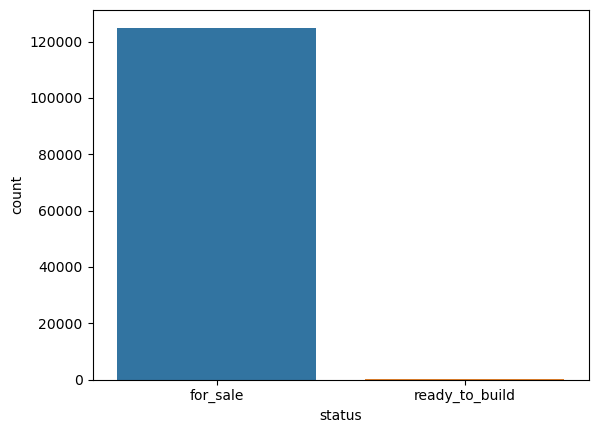

In [10]:
sns.countplot(x='status', data=df)
plt.show()

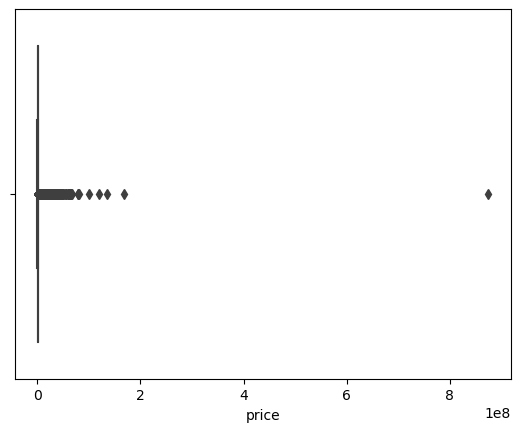

In [11]:
sns.boxplot(x='price', data=df)
plt.show()

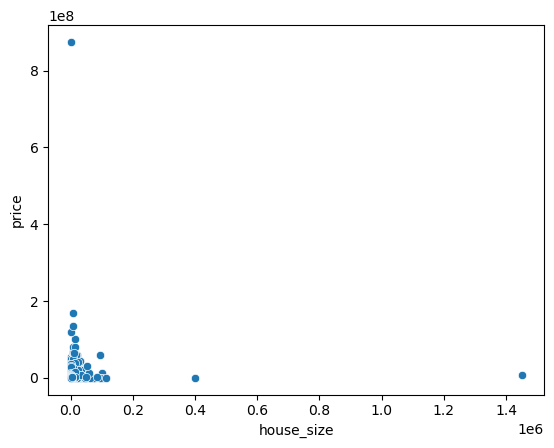

In [12]:
sns.scatterplot(x='house_size', y='price', data=df)
plt.show()

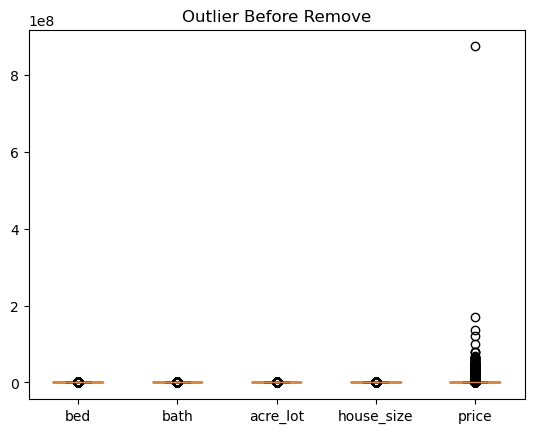

Total Row With Outlier: 125231


In [13]:
column_num = ['bed','bath','acre_lot','house_size','price']
plt.boxplot(df[column_num])
plt.xticks([1, 2, 3, 4, 5], column_num)
plt.title('Outlier Before Remove')
plt.show()
print(f'Total Row With Outlier: {df.shape[0]}')

In [14]:
# REmove Outliers
df['price'] = np.log1p(df['price'])
df['acre_lot'] = np.log1p(df['acre_lot'])
df['house_size'] = np.log1p(df['house_size'])
df['bed'] = np.log1p(df['bed'])
df['bath'] = np.log1p(df['bath'])

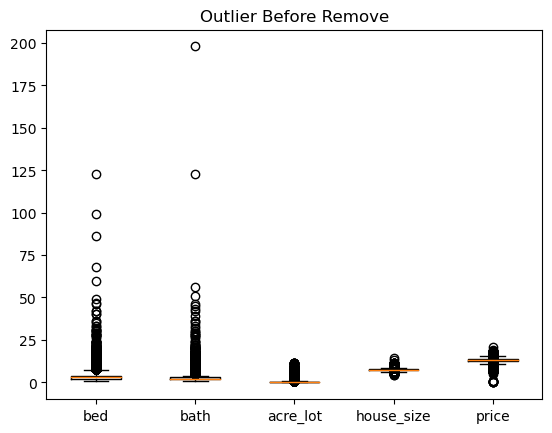

Total Row With Outlier: 125231


In [15]:
column_num = ['bed','bath','acre_lot','house_size','price']
plt.boxplot(df[column_num])
plt.xticks([1, 2, 3, 4, 5], column_num)
plt.title('Outlier AFter Remove')
plt.show()
print(f'Total Row With Outlier: {df.shape[0]}')

C:\Users\USER\AppData\Local\Temp\ipykernel_3984\488824891.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(),


<function matplotlib.pyplot.show(close=None, block=None)>

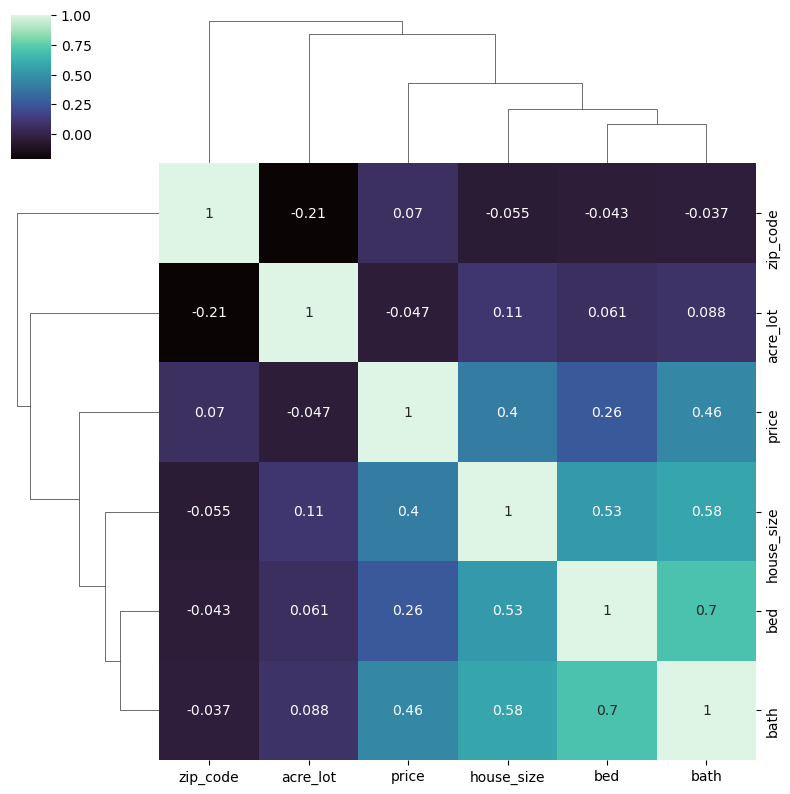

In [16]:
sns.clustermap(
    df.corr(),
    annot=True,
    cmap='mako',
    figsize=(8, 8)
)
plt.show

In [17]:
df['price'].value_counts()

13.303019    978
13.120363    946
12.896719    921
13.457407    875
12.959847    848
            ... 
12.311437      1
13.708817      1
14.092300      1
13.171152      1
14.380257      1
Name: price, Length: 7775, dtype: int64

# MODEL PREDICTING PRICE HOUSE

## Splitting the Data to Train and Test Sets

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [19]:
df['house_size'] = StandardScaler().fit_transform(df['house_size'].values.reshape(len(df), 1))
df['price'] = StandardScaler().fit_transform(df['price'].values.reshape(len(df), 1))

In [20]:
df['bed'] = MinMaxScaler().fit_transform(df['bed'].values.reshape(len(df), 1))
df['bath'] = MinMaxScaler().fit_transform(df['bath'].values.reshape(len(df), 1))
df['acre_lot'] = MinMaxScaler().fit_transform(df['acre_lot'].values.reshape(len(df), 1))

In [21]:
df = df.sample(frac=0.02, random_state=42)

X = df[['bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'city', 'state']]
y = df['price']

# one-hot encode the categorical features
X = pd.get_dummies(X, columns=['city', 'state'])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree Regression

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Define the parameter grid
param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Initialize the Decision Tree regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(dt_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Fit the model on the training set using best parameters
dt_regressor = DecisionTreeRegressor(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], random_state=42)
dt_regressor.fit(X_train, y_train)

# Make predictions on the testing set
dt_predictions = dt_regressor.predict(X_test)

# Calculate the metrics
mse_DT = mean_squared_error(y_test, dt_predictions)
rmse_DT = mean_squared_error(y_test, dt_predictions, squared=False)
r2_DT = r2_score(y_test, dt_predictions)

print(f"Best parameters: {best_params}")

Best parameters: {'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 2}


In [23]:
# Print results for Decision Tree Regression
print("Decision Tree Regression:")
print(f"MSE: {mse_DT}")
print(f"RMSE: {rmse_DT}")
print(f"R^2 Score: {r2_DT}")

Decision Tree Regression:
MSE: 0.39813558066206794
RMSE: 0.6309798575723855
R^2 Score: 0.5525156464121388


In [49]:
# Define an acceptable error range
error_range = 0.9

# Calculate the absolute percent error for each prediction
errors = np.abs((y_test - dt_predictions) / y_test)

# Calculate the percentage of predictions that fall within the error range
accuracy = 100 * np.mean(errors < error_range)

print(f"Accuracy: {accuracy}%")

Accuracy: 65.6686626746507%


# Support Vector Machine (SVM) Regression

In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
}

# Initialize the SVM regressor
svm_regressor = SVR(kernel='rbf')

# Initialize the Grid Search model
grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the training set
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f"Best parameters: {best_params}")

# Fit the model with the best parameters on the training set
svm_regressor_best = SVR(kernel='rbf', C=best_params['C'], epsilon=best_params['epsilon'])
svm_regressor_best.fit(X_train, y_train)

# Make predictions on the testing set
svm_predictions_best = svm_regressor_best.predict(X_test)

# Calculate the metrics
mse_SVM_best = mean_squared_error(y_test, svm_predictions_best)
rmse_SVM_best = mean_squared_error(y_test, svm_predictions_best, squared=False)
r2_SVM_best = r2_score(y_test, svm_predictions_best)

Best parameters: {'C': 100, 'epsilon': 0.2}


In [25]:

# Print results for SVM Regression with best parameters
print("SVM Regression with best parameters:")
print(f"MSE: {mse_SVM_best}")
print(f"RMSE: {rmse_SVM_best}")
print(f"R^2 Score: {r2_SVM_best}")

SVM Regression with best parameters:
MSE: 0.7307704226417572
RMSE: 0.8548511113882681
R^2 Score: 0.1786508263009653


In [48]:
# Define an acceptable error range
error_range = 0.9

# Calculate the absolute percent error for each prediction
errors = np.abs((y_test - svm_predictions_best) / y_test)

# Calculate the percentage of predictions that fall within the error range
accuracy = 100 * np.mean(errors < error_range)

print(f"Accuracy: {accuracy}%")


Accuracy: 50.29940119760479%


# k-Nearest Neighbors (KNN) Regression

In [26]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Specify the range of neighbors
neighbors = np.arange(1, 30)

# Feature selection
selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Specify the hyperparameter space
param_grid = {'knn__n_neighbors': neighbors, 'knn__weights': ['uniform', 'distance'], 'knn__p': [1, 2, 3]}

# Create KNN regressor
knn_regressor = KNeighborsRegressor()

# Create a pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', knn_regressor)])

# Instantiate the GridSearchCV object: knn_cv
knn_cv = GridSearchCV(pipe, param_grid, cv=10)

# Fit to the training set
knn_cv.fit(X_train_selected, y_train)

# Predict the labels of the test set: y_pred
y_pred = knn_cv.predict(X_test_selected)

# Compute and print metrics
mse_KNN = mean_squared_error(y_test, y_pred)
rmse_KNN = mean_squared_error(y_test, y_pred, squared=False)
r2_KNN = r2_score(y_test, y_pred)

In [27]:
print("Tuned KNN Regression Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))
print("MSE: {}".format(mse_KNN))
print("RMSE: {}".format(rmse_KNN))
print("R^2 Score: {}".format(r2_KNN))

Tuned KNN Regression Parameters: {'knn__n_neighbors': 28, 'knn__p': 2, 'knn__weights': 'uniform'}
Best score is 0.47572992513949275
MSE: 0.4724146093923868
RMSE: 0.6873242389094005
R^2 Score: 0.4690297567530243


In [47]:
# Define an acceptable error range
error_range = 0.9

# Calculate the absolute percent error for each prediction
errors = np.abs((y_test - y_pred) / y_test)

# Calculate the percentage of predictions that fall within the error range
accuracy = 100 * np.mean(errors < error_range)

print(f"Accuracy: {accuracy}%")


Accuracy: 62.07584830339321%
